<a href="http://landlab.github.io"><img style="float: left" src="../../../landlab_header.png"></a>

# Importing Landlab .obj format output into Blender

*(This tutorial was written as a collaboration between geology professor Greg Tucker and Vancouver-based visual effects artist Rees Tucker. First version August 2023.)*

<hr>
<small>For more Landlab tutorials, click here: <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html</a></small>
<hr>

[Blender](https://www.blender.org/) is a free and open source 3D computer graphics software package. The Blender developers' vision is that "Everyone should be free to create 3D CG content, with free technical and creative production means and free access to markets." This tutorial describes the basics of getting Landlab output into Blender, using the Wavefront .obj output format.

## Creating a Landlab model as an example

To provide an example, we will create a little landscape evolution simulation using Landlab components, and export its final configuration at the end of the run as an `.obj` format file. (You can learn more about this file format [here](https://www.marxentlabs.com/obj-files/)).

Begin with some imports:

In [ ]:
import numpy as np

from landlab import HexModelGrid, imshow_grid
from landlab.components import (
    FlowAccumulator,
    StreamPowerEroder,
    TaylorNonLinearDiffuser,
)
from landlab.io.obj import write_obj

Set some parameters:

In [ ]:
nrows = 50  # number of node rows
ncols = 80  # number of node columns
node_spacing = 50.0  # distance between adjacent nodes, m
K_sp_mean = 1.0e-5  # stream power erosion coefficient, 1/y, spatial mean
K_sp_std = 2.0e-6  # stream power erosion coefficient, 1/y, standard deviation
seed = 0  # random seed
dt = 1000.0  # time-step duration, y
uprate = 0.001  # maximum uplift rate, m/y
num_steps = 1000  # number of time steps

Define an "uplift function" that will generate a mountain range surrounded by an area of lower relief.

In [ ]:
def uplift_fn(x, y):
    xmax = np.amax(x)
    ymax = np.amax(y)
    u = (x / xmax) * (y / ymax) * (xmax**2 - x**2) * (ymax**2 - y**2)
    return u / np.amax(u)

Create a grid (in this case, a `HexModelGrid`, though raster would work too), and initialize an elevation field with some random noise. Also create an array of erodibility values with some random noise, plus an array to represent the uplift rate in space.

In [ ]:
grid = HexModelGrid((nrows, ncols), spacing=node_spacing, node_layout="rect")
grid.dx = (
    grid.spacing
)  # temporary hack to enable TaylorNonLinearDiffuser to work with hex grid
elev = grid.add_zeros("topographic__elevation", at="node")
elev[grid.core_nodes] = np.random.rand(grid.number_of_core_nodes)
K_sp = K_sp_mean + K_sp_std * np.random.randn(grid.number_of_nodes)
u = uplift_fn(grid.x_of_node, grid.y_of_node)

Instantiate three Landlab components: a `FlowAccumulator` to route flow across the gridded terrain, a `StreamPowerEroder` to simulate erosion by running water, and a `TaylorNonLinearDiffuser` to represent mass transport by gravitational processes.

In [ ]:
fa = FlowAccumulator(grid)
sp = StreamPowerEroder(grid, K_sp=K_sp)
td = TaylorNonLinearDiffuser(grid, linear_diffusivity=0.005)

Loop to simulate the evolution of the landscape.

In [ ]:
for i in range(num_steps):
    elev[grid.core_nodes] += u[grid.core_nodes] * uprate * dt
    fa.run_one_step()
    sp.run_one_step(dt)
    td.run_one_step(dt)

Inspect the resulting terrain with an image color-coded to represent cell elevation values.

In [ ]:
imshow_grid(grid, elev)

Write the grid nodes and associated elevations to an `.obj` format file (note: the `topographic__elevation` field is the default choice for the $z$ coordinate of nodes).

In [ ]:
write_obj("test_mts.obj", grid, clobber=True)

## Installing Blender

The first step is to download and install the Blender application from [https://www.blender.org/download/](https://www.blender.org/download/).

## Reading the output file into Blender

*(Note that this tutorial is written around Blender version 3.6.2 for MacOS; future versions may appear different from the screenshots below)*

1. Open Blender. By default the session starts with a single object: a cube. Type `x` to delete the cube, and verify this in the pop-up window that asks whether you really want to delete it.

2. From the `File` menu select `Import` then `Wavefront (.obj)`. Locate a file called `test_mts.obj` in the same folder as this notebook, and select it.

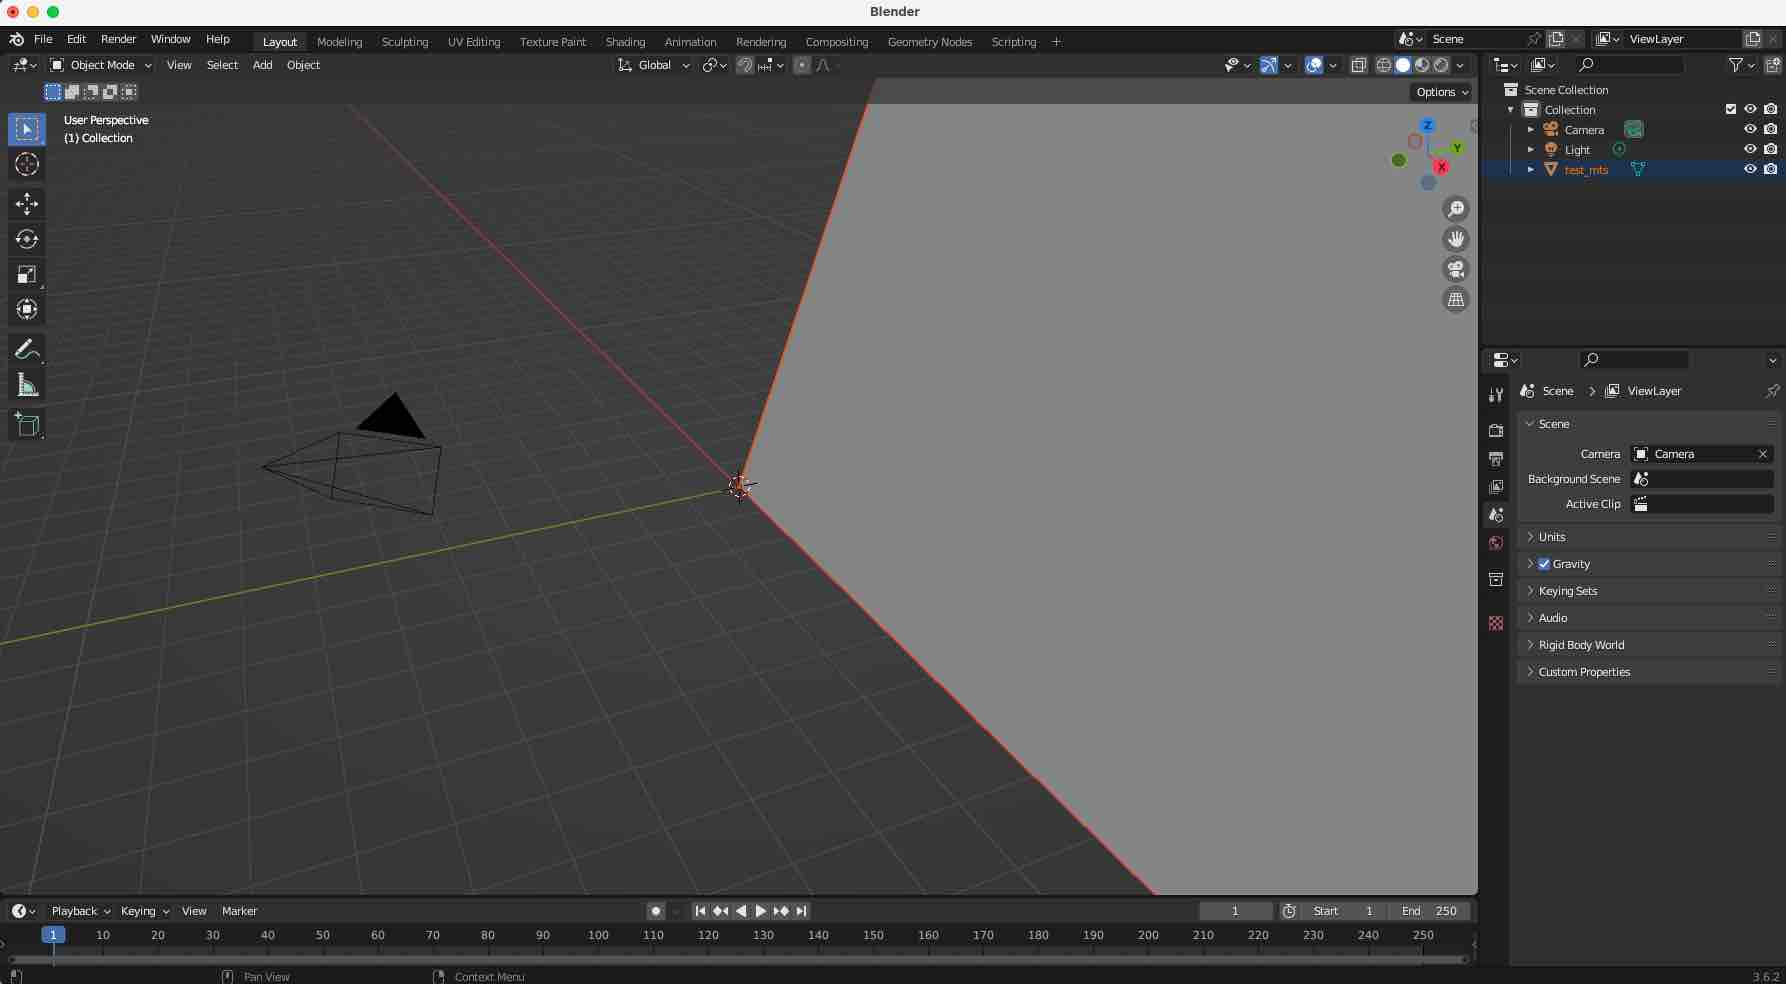




3. Before we go any further, it will be helpful to change the *clipping plane* to make our image completely visible. In the upper right of the main view pane, look for a small left-pointing chevron (just to the right of a colorful set of axes labeled X Y Z, see red circle in image below):

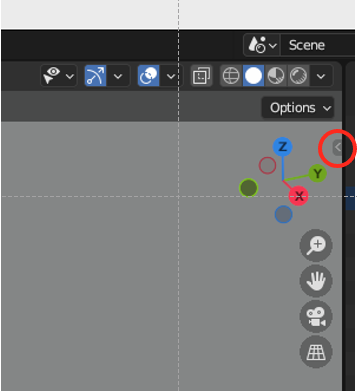



4. Click this to open a small window, then select the View tab next to it:

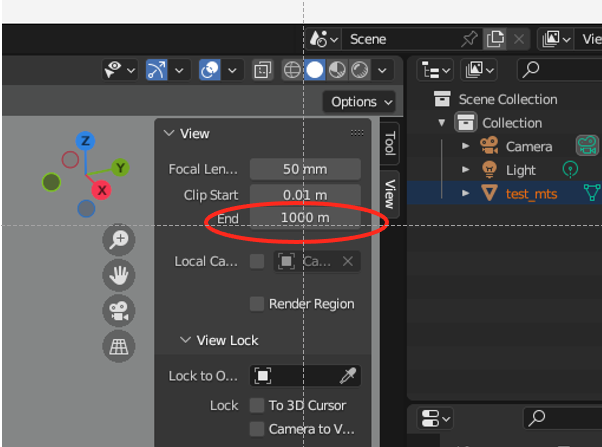

5. Change the value under "End" from 1000 m to 10000 m.



## Viewing the model in Blender

*(Note 1: Blender is a powerful 3D modeling package, and the following only scratches the surface a little bit to help you get started!)*

*(Note 2: To do the next steps, it really helps to have a mouse with a scroll wheel)*

* Zoom in and out of the image with the mouse scroll wheel (trying zooming out until the entire terrain is visible in the window)

* Rotate your view of the image by holding down the middle mouse button / scroll wheel and dragging

* Pan your view of the image by holding down the shift key and the middle mouse button / wheel and dragging while the image is selected

### Some default keyboard shortcuts

#### On the numeric keypad (if your keyboard has one)

2, 4, 6, 8 = rotate view down / left / right / up (respectively)

0 = place the viewpoint at the position of the camera

1, 3, 7 = snap view along y-axis / x-axis / z-axis (respectively) (notice how the guide axes in upper right change)

5 = toggle between perspective and orthographic view

9 = rotate view 180 degrees

#### On the "main" part of the keyboard

Tab = toggle between object mode and edit mode; note that you need to be in edit mode for the following keyboard shortcuts.

1 = toggle vertex select mode

2 = toggle edge select mode

3 = toggle face select mode

a = select all (alt-a to unselect all)

r = toggle rotate mode. You can rotate the whole object or an individually selected element; holding down the `x` key while you rotate will limit rotation to the x-axis; holding Shift-x will limit rotation to the other two axes. The same functionality applies with `y` and `z`. Holding the control key while rotating causes rotation to snap to finite increments (e.g., 15 degrees). Left-click keeps the rotation, and right-click discards it.

s = toggle scale mode. Limiting scale to x, y, or z axes works the same as with rotation.

g = toggle grab mode, which allows you to "grab" the object and move it around. As above, motion can be limited to just one or two axes.

z = hold this key down to select the view mode. Options are *Solid* (the default), *Wireframe*, *Material preview*, and *Rendered*. 





## Applying Subdivision

Blender can automatically subdivide a model, adding additional vertices and faces to increase the level of detail. For a Landlab-generated model, this can help add smoothness to the image. (Be careful: too much subdivision and the model can become too big for the computer to handle.)

To apply subdivision:

1. From the column of icons just to the (lower) right of the main view pane, select the one that looks like a blue wrench.

2. From the drop-down menu *Add Modifier* select *Subdivision Surface*

3. The *Levels Viewport* allows you to choose a number of levels of subdivision for the model as it appears in the viewport. The subdivision level represents the number of times subdivision will be applied. Try setting it to 2, meaning that the original grid elements will be subdivided into smaller elements once, and then those smaller elements will again be subdivided on a second pass. (The *Render* box sets the recursion levels for the rendered image; often 3D designers will keep the viewport subdivision smaller than the rendered version for the purpose of speed in object editing)

Here's a version of our terrain model with 2 levels of subdivision, with the lighting on viewport shading also changed to a brownish hue (hint: see the buttons and drop-down arrow on the upper-right of the viewport):

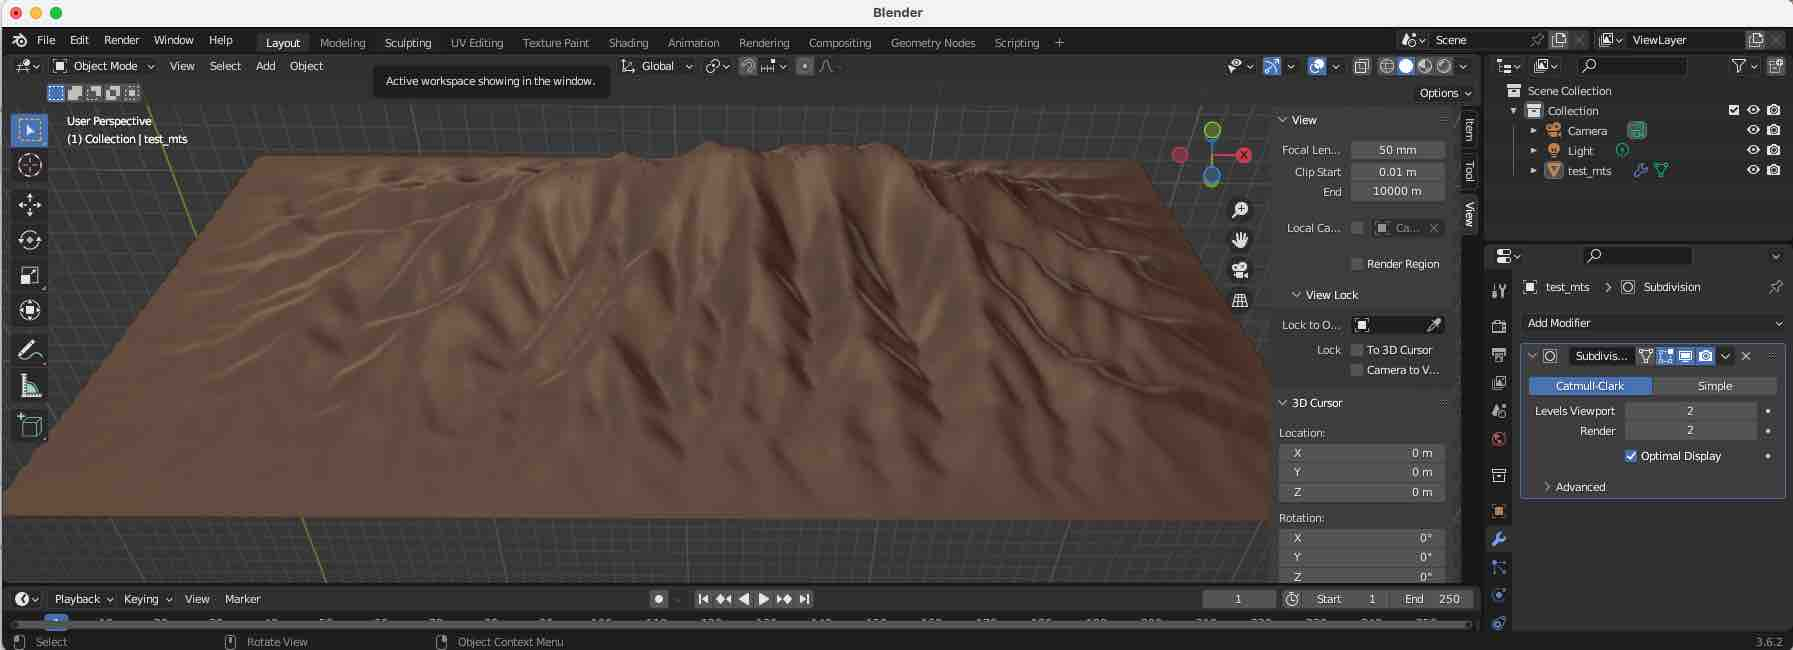


Blender is an incredibly powerful package, and this brief tutorial has only scratched the surface of what's possible. If you find interesting new tricks or applications, we would love to hear about it on the [CSDMS Forum](https://github.com/csdms/welcomes/discussions) or elsewhere!

The Forum can be found at:

https://github.com/csdms/welcomes/discussions


### Click here for more <a href="https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html">Landlab tutorials</a>